In [31]:
# Importing the libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats

In [17]:
# Load the dataset
dataset = pd.read_csv(r'input/data/240624_validation_data.csv')

time = dataset['time']
forecast_demand = dataset['predicted heat']
actual_demand = dataset['delivered heat']

df_data = pd.DataFrame({'time' : time, 'actual_demand': actual_demand, 'forecast_demand': forecast_demand})

In [43]:
# Calculate the error and absolute error
df_data['error']= df_data['actual_demand'] - df_data['forecast_demand']
df_data['abs_error']= abs(df_data['error'])

# Mean and standard deviation of the error
mean_error = df_data['error'].mean()
std_error = df_data['error'].std()

#Print the mean and standard deviation of the error
print('Mean error:', mean_error)
print('Standard deviation of the error:', std_error)


Mean error: -8.39020298257356
Standard deviation of the error: 31.42172005784749


In [27]:
df_data


,time,actual_demand,forecast_demand,error,abs_error
0,2023-03-02 17:00:00+01:00,254.990005,255.590651,-0.600646,0.600646
1,2023-03-02 18:00:00+01:00,187.787503,237.501176,-49.713673,49.713673
2,2023-03-02 19:00:00+01:00,230.629171,264.220971,-33.591800,33.591800
3,2023-03-02 20:00:00+01:00,233.329169,236.491860,-3.162691,3.162691
4,2023-03-02 21:00:00+01:00,222.775003,216.179837,6.595167,6.595167
...,...,...,...,...,...
2996,2023-07-12 21:00:00+02:00,55.804167,51.912949,3.891219,3.891219
2997,2023-07-12 22:00:00+02:00,14.191667,37.334409,-23.142742,23.142742
2998,2023-07-12 23:00:00+02:00,22.533334,37.278034,-14.744700,14.744700
2999,2023-07-13 00:00:00+02:00,15.287500,37.703201,-22.415700,22.415700


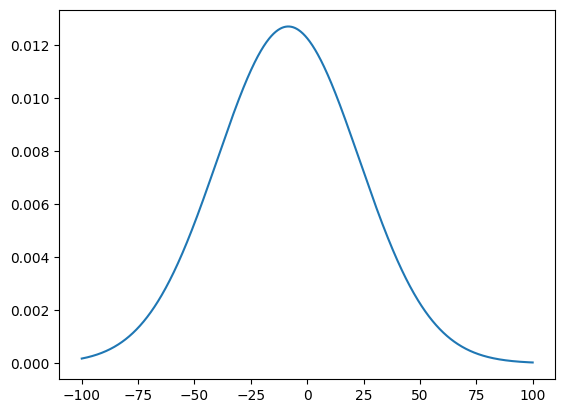

In [42]:
x = np.linspace(-100, 100, 1000)
function=stats.norm.pdf(x,mean_error,std_error)
plt.plot(x, function, label='Normal Distribution')

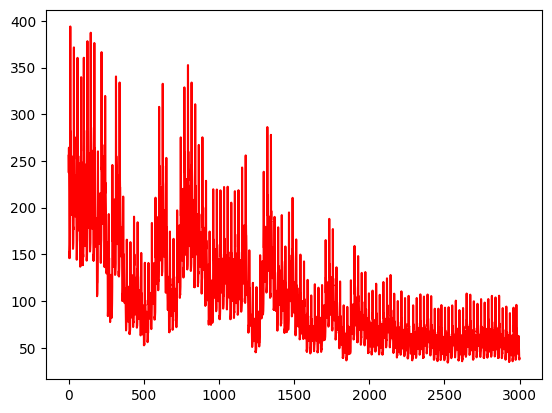

In [10]:
# Visualising the data
plt.plot(forecast_demand, color = 'red', label = 'Forecast Demand')